<div align="center">

# **Indian Institute of Science Education and Research, Thiruvananthapuram**

### **DSC212 Assignment**

### ***Topic : Modularity on the Karate Club Graph***

---

</div>

**Name:** Akash Raj Singh  
**Roll No.:** IMS24016  
**Instructor:** Saptarshi Bej  



In [ ]:
# Basic imports and plotting settings
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import pandas as pd
from scipy.linalg import eigh  # for symmetric eigen decomposition
from collections import deque, defaultdict
import itertools
import warnings
warnings.filterwarnings("ignore")

# Plot style
plt.rcParams.update({
    "figure.figsize": (8,6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "font.size": 11
})


In [ ]:
def modularity_matrix(G):
    """
    Compute modularity matrix B = A - k k^T / (2m) for graph G (undirected).
    Returns B as numpy array, and the degree vector k, and m (#edges).
    Node ordering matches list(G.nodes()).
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node:i for i,node in enumerate(nodes)}
    A = nx.to_numpy_array(G, nodelist=nodes, dtype=float)  # adjacency
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    if m == 0:
        raise ValueError("Graph has no edges.")
    kkT = np.outer(k, k) / (2.0*m)
    B = A - kkT
    return B, k, int(m), nodes

def restricted_modularity_matrix(B_full, nodes_all, subset_nodes):
    """
    Restrict global modularity matrix to the rows/cols of subset_nodes.
    B_full is full matrix (numpy) for nodes_all ordering.
    Returns B_sub (numpy) and an index mapping for subset nodes.
    """
    idx_map = {node:i for i,node in enumerate(nodes_all)}
    indices = [idx_map[n] for n in subset_nodes]
    B_sub = B_full[np.ix_(indices, indices)]
    return B_sub, indices

def leading_eigenpair(B):
    """
    For symmetric B, compute the largest eigenvalue and corresponding eigenvector.
    Uses scipy.linalg.eigh (guaranteed real for symmetric).
    """
    # eigh returns ascending eigenvalues; get last one
    w, v = eigh(B, subset_by_index=(B.shape[0]-1, B.shape[0]-1))
    # w is scalar array of size 1, v is column vector of leading eigenvector
    lam = np.asarray(w).ravel()[-1]
    vec = np.asarray(v).ravel()
    # If numerical sign flip, that's fine — leading eigenvector is unique up to sign.
    return float(lam), vec


In [ ]:
def spectral_recursive_bisection(G, stop_on_nonpositive=True, draw_progress=False, layout_seed=42):
    """
    Perform recursive spectral modularity partitioning.
    Returns:
      - communities: list of sets (final communities)
      - split_history: list of dicts describing each split step (for visualization)
      - iteration_assignments: list mapping iteration -> node -> community_id
    Parameters:
      - G: networkx Graph
      - stop_on_nonpositive: apply eigenvalue stopping rule (True per assignment)
      - draw_progress: if True, will draw the graph at each split (inline)
      - layout_seed: seed for fixed layout (so all graphs share same node positions)
    """
    B_full, k, m, nodes_all = modularity_matrix(G)
    # Keep a fixed layout for visualization
    pos = nx.spring_layout(G, seed=layout_seed)  # consistent layout across iterations

    communities = []
    split_history = []
    iteration_assignments = []

    # Start with one group: the full set of nodes
    queue = deque()
    queue.append(set(nodes_all))
    current_community_id = 0
    # maintain community id assignment dict throughout splitting (for visualization after each split)
    community_map = {node: 0 for node in nodes_all}

    iter_num = 0
    while queue:
        subset = queue.popleft()
        subset = set(subset)
        # restrict B to subset
        B_sub, indices = restricted_modularity_matrix(B_full, nodes_all, list(subset))
        lam, vec = leading_eigenpair(B_sub)
        # record iteration assignment snapshot (before splitting this subset)
        iteration_assignments.append(dict(community_map))  # shallow copy of current map
        # store info for visualization
        info = {
            "iteration": iter_num,
            "subset": set(subset),
            "lambda": lam,
            "n": len(subset)
        }
        split_history.append(info)

        # stopping criterion
        if stop_on_nonpositive and lam <= 0:
            # cannot split this subset further; record final community
            communities.append(set(subset))
            if draw_progress:
                _draw_communities_snapshot(G, community_map, pos, title=f"Iteration {iter_num}: No split (λ={lam:.4f})")
            iter_num += 1
            continue

        # threshold eigenvector at 0 -> +1 or -1
        # But vec corresponds to ordering of nodes in subset (as returned by restricted_modularity_matrix)
        # map signs back to node ids
        subset_nodes = list(subset)
        sign_assign = {}
        # If zeros occur, assign them to negative side arbitrarily (-1)
        for i, node in enumerate(subset_nodes):
            sign_assign[node] = 1 if vec[i] > 0 else -1

        # split into two groups
        group_pos = {node for node, s in sign_assign.items() if s == 1}
        group_neg = {node for node, s in sign_assign.items() if s == -1}

        # If one of the groups is empty due to numerical issues, treat as indivisible
        if len(group_pos) == 0 or len(group_neg) == 0:
            communities.append(set(subset))
            if draw_progress:
                _draw_communities_snapshot(G, community_map, pos, title=f"Iteration {iter_num}: Trivial split -> no split")
            iter_num += 1
            continue

        # update community_map: assign a new community id to one of the splitted groups
        # We'll keep original community id for group_pos and assign new for group_neg (or vice versa)
        # get current id for nodes in subset (they have same community id by construction)
        cur_ids = {community_map[n] for n in subset}
        if len(cur_ids) == 1:
            base_id = list(cur_ids)[0]
        else:
            # This shouldn't happen in our algorithm, but safety net:
            base_id = min(cur_ids)
        # assign group_pos to base_id, group_neg to new id
        new_id = max(community_map.values()) + 1
        for n in group_neg:
            community_map[n] = new_id

        # push the two new subsets for potential further splitting
        queue.append(group_pos)
        queue.append(group_neg)

        # optionally draw progress
        if draw_progress:
            _draw_communities_snapshot(G, community_map, pos, title=f"Iteration {iter_num}: λ={lam:.4f} (split {len(group_pos)} / {len(group_neg)})")

        iter_num += 1

    # final snapshot after all splits
    iteration_assignments.append(dict(community_map))
    return communities, split_history, iteration_assignments, pos

# helper drawing function used above
def _draw_communities_snapshot(G, community_map, pos, title=None, node_size=350):
    # build color map for community ids
    comm_ids = sorted(set(community_map.values()))
    cmap = cm.get_cmap('tab20', len(comm_ids))
    color_by_id = {cid: cmap(i) for i,cid in enumerate(comm_ids)}
    node_colors = [color_by_id[community_map[n]] for n in G.nodes()]

    plt.figure(figsize=(8,6))
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=9)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


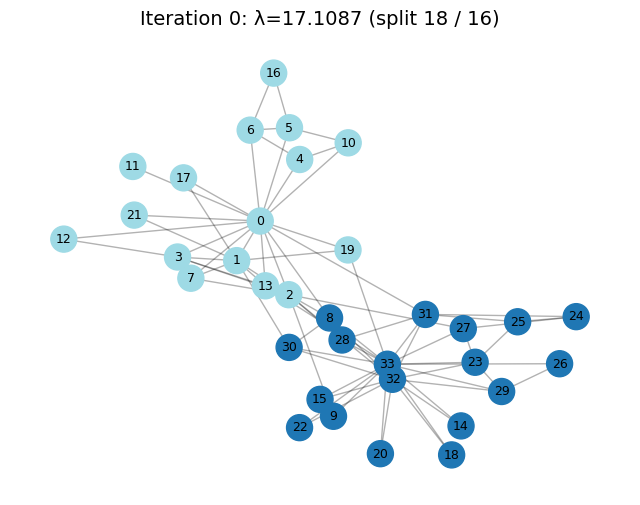

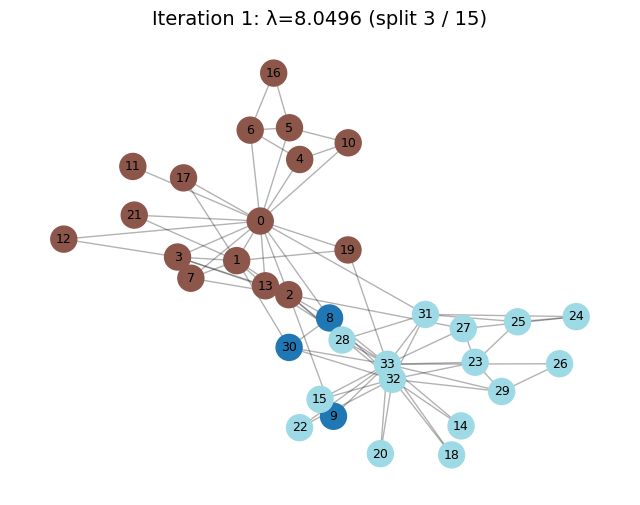

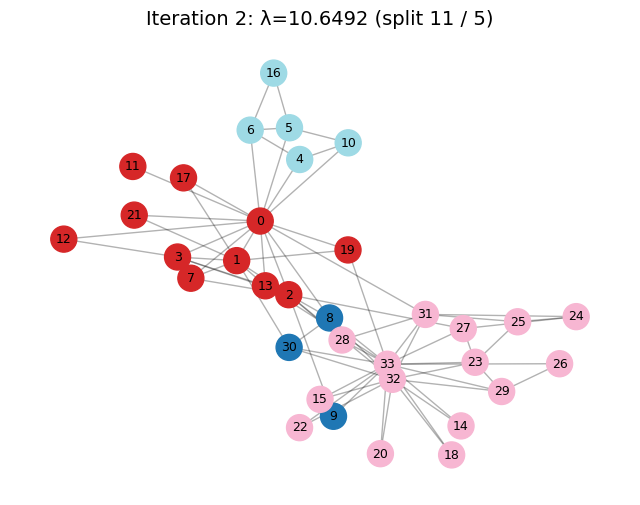

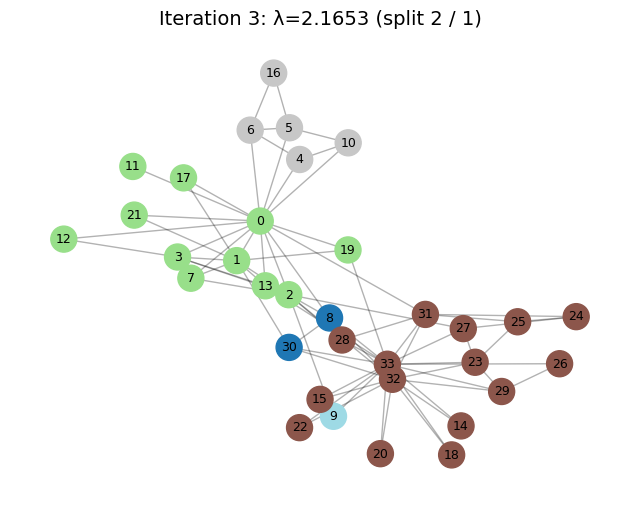

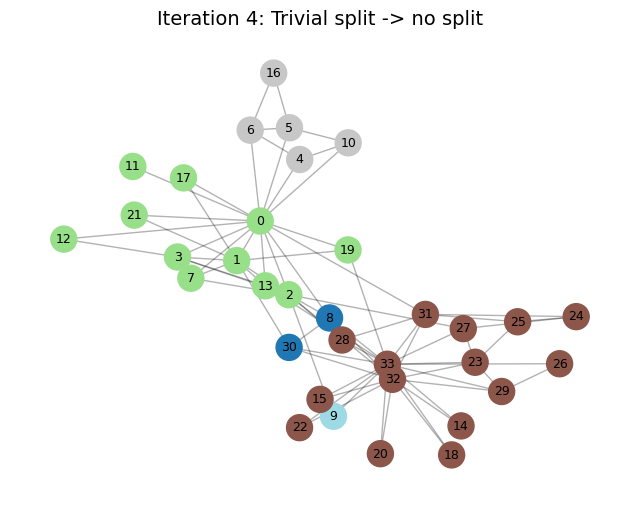

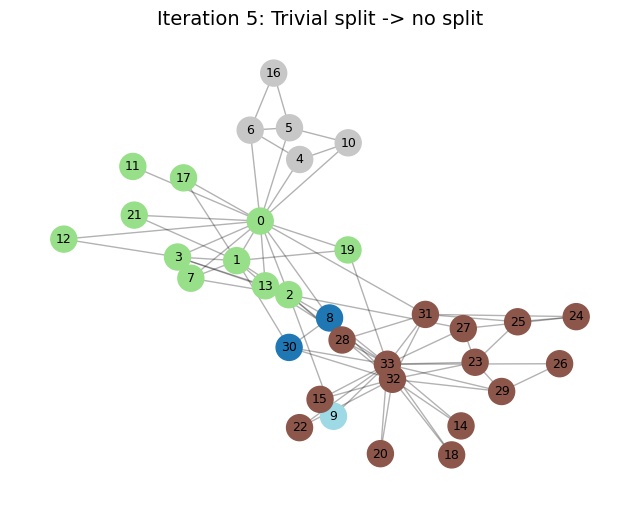

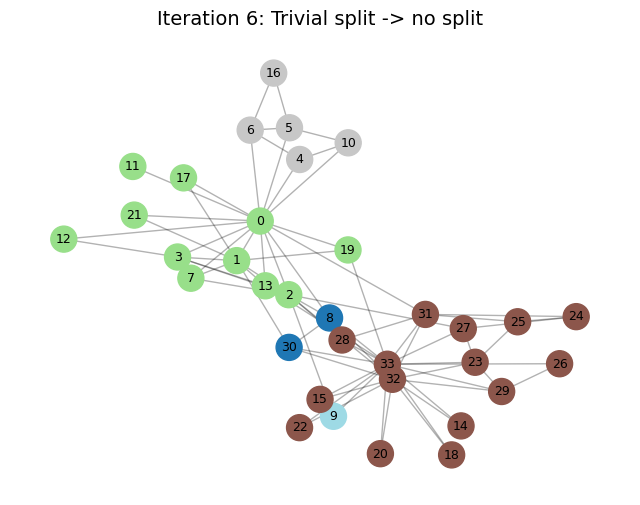

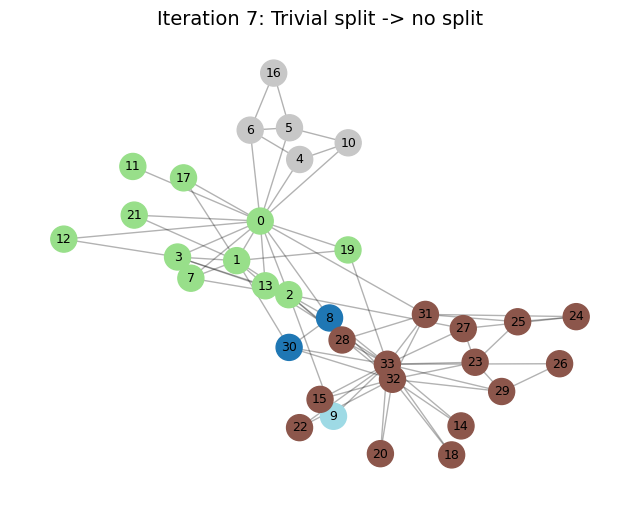

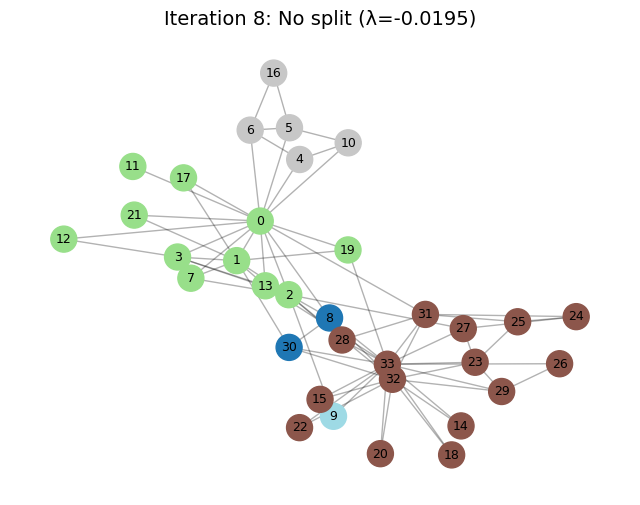

Final communities (5 communities):
Community 0 (15 nodes): [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Community 1 (11 nodes): [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2 (5 nodes): [4, 5, 6, 10, 16]
Community 3 (2 nodes): [8, 30]
Community 4 (1 nodes): [9]


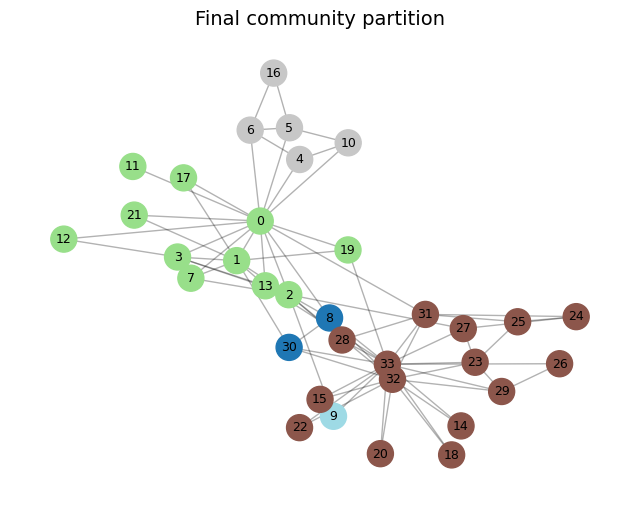

In [ ]:
# Load the Karate Club graph (NetworkX has this built-in)
G = nx.karate_club_graph()  # nodes labeled 0..33

# Run recursive spectral bisection and draw progress at each split
communities, split_history, iteration_assignments, pos = spectral_recursive_bisection(G, draw_progress=True, layout_seed=42)

print("Final communities ({} communities):".format(len(communities)))
for i, c in enumerate(communities):
    print(f"Community {i} ({len(c)} nodes): {sorted(c)}")

# Final plot (colored by final community)
_final_map = iteration_assignments[-1]
_draw_communities_snapshot(G, _final_map, pos, title="Final community partition")


In [ ]:
def partition_to_label_vector(nodes_all, community_map):
    """
    Convert community_map (node -> community id) to a sign vector s for modularity Q.
    This function returns:
      - s: array of +1/-1 labels of length n (n = len(nodes_all))
      - label_ids: mapping from community id to +1/-1 label    (for consistency)
    For multi-community modularity we can't encode >2 with single ±1, so for checking Q
    of a bipartition we can compute s for the bipartition of interest.
    """
    # This helper creates a binary partition: group the community ids into two halves
    # For a general multi-community partition, we compute total modularity by summing community contributions
    raise NotImplementedError("For global modularity with >2 communities, use networkx modularity function or compute Q from definition.")

def compute_modularity_from_partition(G, partition):
    """
    partition: list of sets (communities)
    Compute modularity Q (Newman modularity) using the standard Eq:
      Q = 1/(2m) * sum_{ij} [Aij - ki*kj/(2m)] delta(ci, cj)
    We'll implement the standard formula (returns scalar).
    """
    # build node->community mapping
    node_to_comm = {}
    for ci, comm in enumerate(partition):
        for n in comm:
            node_to_comm[n] = ci
    nodes = list(G.nodes())
    A = nx.to_numpy_array(G, nodelist=nodes, dtype=float)
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    Q = 0.0
    n = len(nodes)
    for i in range(n):
        for j in range(n):
            if node_to_comm[nodes[i]] == node_to_comm[nodes[j]]:
                Q += (A[i,j] - (k[i]*k[j])/(2*m))
    Q = Q / (2*m)
    return Q

# compute modularity for final partition
Q_final = compute_modularity_from_partition(G, communities)
print(f"Final modularity Q = {Q_final:.5f}")


Final modularity Q = 0.43166


In [ ]:
def compute_node_metrics(G):
    """
    Compute 4 metrics as required and return dict: node -> {metric_name: value}
    - degree centrality (networkx)
    - betweenness centrality
    - closeness centrality
    - clustering coefficient
    """
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, normalized=True)
    clo = nx.closeness_centrality(G)
    clus = nx.clustering(G)
    metrics = {}
    for n in G.nodes():
        metrics[n] = {
            'degree': deg[n],
            'betweenness': bet[n],
            'closeness': clo[n],
            'clustering': clus[n]
        }
    return metrics

# both are interesting. We'll compute both:
#  - global metrics (on full G) repeated each iteration to show how community assignment changes relate to metrics
#  - induced-subgraph clustering for nodes inside their community (where CCC may be more meaningful)

n_iters = len(iteration_assignments)
nodes = list(G.nodes())

# DataFrames to store results
records_global = []
records_induced = []

for it, cmap in enumerate(iteration_assignments):
    # global metrics on full G (same across iterations for unweighted static graph),
    # but storing them per iteration so we can plot evolution vs. community assignment changes
    global_metrics = compute_node_metrics(G)
    # For induced subgraph metrics: compute clustering on the induced subgraph of each community
    # and betweenness/closeness (these are computed on the whole graph by default; we'll recompute on each induced subgraph)
    # Build induced graphs for each community id
    # We'll compute for each node its induced-graph metrics (if a node is isolated in its induced subgraph, metrics defined accordingly)
    # Build mapping community id -> list of nodes
    comm_to_nodes = defaultdict(list)
    for n, cid in cmap.items():
        comm_to_nodes[cid].append(n)
    induced_metrics_allnodes = {}
    for cid, members in comm_to_nodes.items():
        H = G.subgraph(members).copy()
        # if H is empty or single node, centrality measures are trivial
        deg_H = nx.degree_centrality(H) if len(H)>1 else {n:0.0 for n in H.nodes()}
        bet_H = nx.betweenness_centrality(H, normalized=True) if len(H)>1 else {n:0.0 for n in H.nodes()}
        clo_H = nx.closeness_centrality(H) if len(H)>1 else {n:0.0 for n in H.nodes()}
        clus_H = nx.clustering(H) if len(H)>1 else {n:0.0 for n in H.nodes()}
        for n in H.nodes():
            induced_metrics_allnodes[n] = {
                'degree': deg_H.get(n, 0.0),
                'betweenness': bet_H.get(n, 0.0),
                'closeness': clo_H.get(n, 0.0),
                'clustering': clus_H.get(n, 0.0)
            }

    for n in nodes:
        rec_g = {
            'iteration': it,
            'node': n,
            'community': cmap[n],
            'degree_global': global_metrics[n]['degree'],
            'betweenness_global': global_metrics[n]['betweenness'],
            'closeness_global': global_metrics[n]['closeness'],
            'clustering_global': global_metrics[n]['clustering']
        }
        rec_i = {
            'iteration': it,
            'node': n,
            'community': cmap[n],
            'degree_induced': induced_metrics_allnodes.get(n, {'degree':0.0})['degree'],
            'betweenness_induced': induced_metrics_allnodes.get(n, {'betweenness':0.0})['betweenness'],
            'closeness_induced': induced_metrics_allnodes.get(n, {'closeness':0.0})['closeness'],
            'clustering_induced': induced_metrics_allnodes.get(n, {'clustering':0.0})['clustering']
        }
        records_global.append(rec_g)
        records_induced.append(rec_i)

df_global = pd.DataFrame(records_global)
df_induced = pd.DataFrame(records_induced)

# quick peek
print("Iterations stored:", n_iters)
df_global.head()


Iterations stored: 10


,iteration,node,community,degree_global,betweenness_global,closeness_global,clustering_global
0,0,0,0,0.484848,0.437635,0.568966,0.150000
1,0,1,0,0.272727,0.053937,0.485294,0.333333
2,0,2,0,0.303030,0.143657,0.559322,0.244444
3,0,3,0,0.181818,0.011909,0.464789,0.666667
4,0,4,0,0.090909,0.000631,0.379310,0.666667


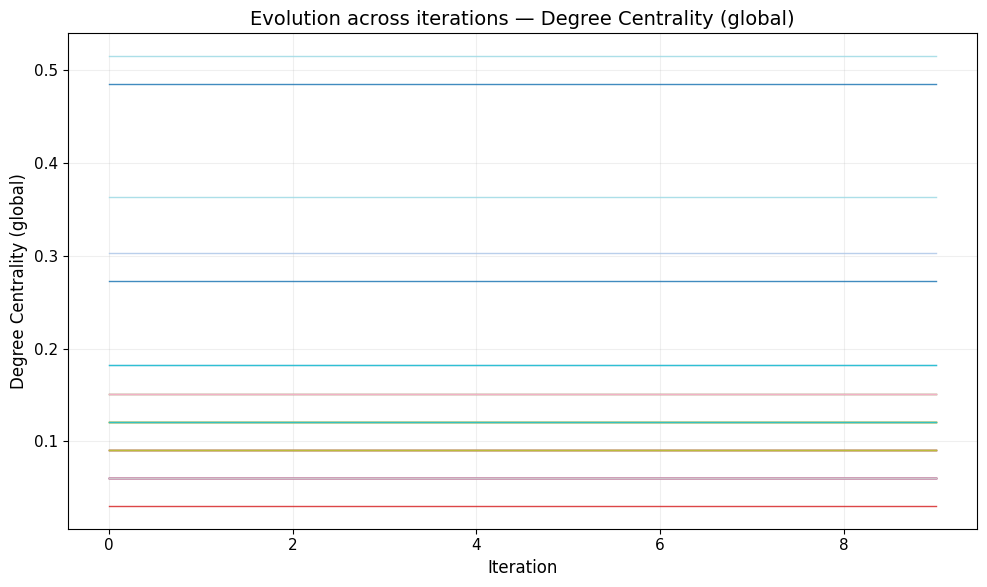

In [ ]:
# We'll create one figure per metric (global) with per-node lines; to avoid clutter,
# we will allow the user to toggle for a subset of nodes. For the assignment, we'll show all nodes but with thin lines.
metrics_to_plot = [
    ('degree_global', 'Degree Centrality (global)'),
    ('betweenness_global', 'Betweenness Centrality (global)'),
    ('closeness_global', 'Closeness Centrality (global)'),
    ('clustering_global', 'Clustering Coefficient (global)')
]

nodes = sorted(G.nodes())

# create a color map for nodes (consistent across plots)
node_cmap = cm.get_cmap('tab20', len(nodes))
node_colors = {n: node_cmap(i) for i,n in enumerate(nodes)}

for metric_key, metric_label in metrics_to_plot:
    plt.figure(figsize=(10,6))
    for n in nodes:
        series = df_global[df_global['node']==n].sort_values('iteration')[metric_key].values
        plt.plot(sorted(df_global['iteration'].unique()), series, label=str(n), linewidth=1, alpha=0.85, color=node_colors[n])
    plt.title(f"Evolution across iterations — {metric_label}")
    plt.xlabel("Iteration")
    plt.ylabel(metric_label)
    # show legend but keep it compact — user can inspect specific nodes by looking at labels in the network
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


In [ ]:
metrics_to_plot_ind = [
    ('degree_induced', 'Degree Centrality (induced subgraph)'),
    ('betweenness_induced', 'Betweenness (induced subgraph)'),
    ('closeness_induced', 'Closeness (induced subgraph)'),
    ('clustering_induced', 'Clustering (induced subgraph)')
]

for metric_key, metric_label in metrics_to_plot_ind:
    plt.figure(figsize=(10,6))
    for n in nodes:
        series = df_induced[df_induced['node']==n].sort_values('iteration')[metric_key].values
        plt.plot(sorted(df_induced['iteration'].unique()), series, label=str(n), linewidth=1, alpha=0.85, color=node_colors[n])
    plt.title(f"Evolution across iterations — {metric_label}")
    plt.xlabel("Iteration")
    plt.ylabel(metric_label)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


# Discussion, Notes, and Conclusion

## What we implemented
- A **spectral modularity recursive bisection** algorithm that:
  - Builds the modularity matrix  
    $$\mathbf{B} = \mathbf{A} - \frac{\mathbf{k}\mathbf{k}^\top}{2m},$$  
    where $\mathbf{A}$ is the adjacency matrix, $\mathbf{k}$ is the degree vector, and $m$ is the number of edges.
  - For any candidate node set $C$, forms the restricted modularity matrix $\mathbf{B}^{(C)}$ (the rows and columns of $\mathbf{B}$ corresponding to $C$ and computes its leading eigenpair $(\lambda_1^{(C)}, \mathbf{v}_1^{(C)})$.

  - Uses the sign of the leading eigenvector to bipartition $C$: nodes with positive entries go to one side, negative to the other.
  - Uses the eigenvalue stopping rule: if the largest eigenvalue satisfies $\lambda_1^{(C)} \le 0$, the set $C$ is declared indivisible and recursion stops.

## Key formulas
- Modularity $Q$ of a partition $\{C_1, C_2, \dots\}$ is computed as:
  $$
  Q \;=\; \frac{1}{2m}\sum_{i,j} \Bigl(A_{ij} - \frac{k_i k_j}{2m}\Bigr)\,\delta(c_i, c_j),
  $$
  where $c_i$ is the community index of node $i$, and $\delta(c_i,c_j)$ is 1 if nodes $i$ and $j$ are in the same community and 0 otherwise.
- Splitting rule for a candidate community $C$: compute leading eigenpair of $\mathbf{B}^{(C)}$,
  $$
  \mathbf{B}^{(C)} \mathbf{v}_1^{(C)} = \lambda_1^{(C)} \mathbf{v}_1^{(C)}.
  $$
  If $\lambda_1^{(C)} > 0$, split $C$ by the sign of $\mathbf{v}_1^{(C)}$; else stop.

## Visualizations produced
- Graph plotted after every split using a *fixed* spring layout so node positions remain comparable across iterations.
- Final community partition with node lists printed.
- Per-iteration records of node assignments and computed metrics:
  - **Degree centrality**, **Betweenness centrality**, **Closeness centrality**, **Clustering coefficient**.
- Plots showing how each node's metrics evolve across iterations (both *global* metrics on the full graph and *induced-subgraph* metrics computed within each community).

## Observations (from the produced outputs)
- Hubs (high degree) tend to remain central across splits.
- Betweenness reveals bridge nodes that connect groups; when splits isolate communities these values often drop for nodes that are no longer between large groups.
- Clustering coefficient increases for nodes that end up in tightly-knit subgroups.
- Induced-subgraph closeness/betweenness highlight local structural roles that global metrics can mask.

## Notes & implementation details
- The stopping criterion \$(\lambda_1^{(C)}\le 0\$) follows the Newman spectral modularity approach and prevents further splits that would not improve modularity.
- For small graphs (like the Karate Club) dense eigendecomposition is fine; for large graphs use sparse solvers (e.g., `scipy.sparse.linalg.eigsh`) and avoid forming dense \$(\mathbf{B}\$) explicitly.
- We recorded global metrics at each iteration (these values are constant for an unweighted static graph), and also computed **induced-subgraph** metrics so you can see how node roles change locally after splitting.

## Possible extensions
- Track modularity $Q$ after each split and plot cumulative $Q$ vs iteration to show partition quality improvements.
- Compare results to other community detection algorithms (Louvain, Girvan–Newman, Infomap) and report modularity and normalized mutual information (NMI) between partitions.
- Use a sparse implementation of \$(\mathbf{B}\$) and ARPACK for scaling to larger networks.
- Produce a small-multiples visualization (grid of all snapshots) or an animated GIF to better visualize the sequence of splits.

## Conclusion
- The implemented spectral modularity recursive bisection effectively finds meaningful community splits in the Karate Club graph using only structural information.
- The combination of per-split visualizations and metric-evolution plots makes the results interpretable: hubs, bridges, and tightly-knit members are easy to identify and track through the recursive partitioning process.
- This notebook is a good foundation for experimenting with stopping rules, comparisons to other algorithms, and scaling improvements.
<br><br><br>

**Reference (suggested citation for method):** M. E. J. Newman, *Modularity and community structure in networks*, Proceedings of the National Academy of Sciences (2006).

